In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import least_squares
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from model.PDV_4_factor import *
from model.data import *

# Download data

In [19]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('1995-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [20]:
# # Load data on SPX and VIX
# spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
# vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [21]:
# spx_data.to_csv('spx_data.csv')
# vix_data.to_csv('vix_data.csv')

In [22]:
spx_data = pd.read_csv('spx_data.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('vix_data.csv', index_col=0, parse_dates=[0])

In [23]:
data = create_df_from_yf(spx_data, vix_data, train_start_date, test_start_date)
data

,r1,r2,vix
1995-01-04,0.003485,1.214534e-05,0.1353
1995-01-05,-0.000803,6.449659e-07,0.1350
1995-01-06,0.000739,5.454954e-07,0.1313
1995-01-09,0.000326,1.060104e-07,0.1333
1995-01-10,0.001845,3.402222e-06,0.1252
...,...,...,...
2018-12-24,-0.027112,7.350743e-04,0.3607
2018-12-26,0.049594,2.459539e-03,0.3041
2018-12-27,0.008563,7.331950e-05,0.2996
2018-12-28,-0.001242,1.541527e-06,0.2834


In [24]:
window = 1000
dataset = VIXDataset(data, window)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Fitting

## SGD

In [8]:
params = torch.tensor([0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5], requires_grad=True)
optimizer = torch.optim.Adam([params], lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

for epoch in range(100):
    losses = []
    for x, y in dataloader:
        preds = torch_predict(params, x)
        loss = nn.MSELoss()(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    epoch_loss = np.mean(losses)
    print(f'Epoch {epoch} Loss {epoch_loss}')
    scheduler.step(epoch_loss)

Epoch 0 Loss 0.0064992486157372025
Epoch 1 Loss 0.005279520007817051
Epoch 2 Loss 0.005158939030422251
Epoch 3 Loss 0.005149896801861969
Epoch 4 Loss 0.005087771349810535
Epoch 5 Loss 0.00509605993210232
Epoch 6 Loss 0.005030235028059422
Epoch 7 Loss 0.005029990608933606
Epoch 8 Loss 0.005017790790128557
Epoch 9 Loss 0.004988691141781739
Epoch 10 Loss 0.004981632880819372
Epoch 11 Loss 0.004958978845278108
Epoch 12 Loss 0.004947811771844384
Epoch 13 Loss 0.0049440427771710515
Epoch 14 Loss 0.004992261029414456
Epoch 15 Loss 0.004953258886013793
Epoch 16 Loss 0.004930074512369082
Epoch 17 Loss 0.004902325573530567
Epoch 18 Loss 0.004894067135439078
Epoch 19 Loss 0.004905457571561483
Epoch 20 Loss 0.0049232009981016196
Epoch 21 Loss 0.004872846418602652
Epoch 22 Loss 0.004914406468926729
Epoch 23 Loss 0.004921352676457808
Epoch 24 Loss 0.0048835745429077855
Epoch 25 Loss 0.00489713891138193
Epoch 26 Loss 0.004897205766196115
Epoch 27 Loss 0.004930051700860451
Epoch 00028: reducing learni

In [9]:
params

tensor([ 0.2019, -3.6025,  2.0378,  0.3598,  0.3598,  0.5000,  0.8656,  0.8656,
         0.5000], requires_grad=True)

In [10]:
residuals = residual(params.detach().numpy(), data, window)
total_sum_of_squares = np.sum((data.iloc[window-1:]['vix'] - np.mean(data.iloc[window-1:]['vix'])) ** 2)
print('Mean: {:.4f}, Min: {:.4f}, Max: {:.4f}, MAE: {:.4f}, MSE: {:.4f}, R^2: {:.4f}'.format(
    np.mean(residuals), np.min(residuals), np.max(residuals), np.mean(np.abs(residuals)), np.mean(residuals**2), (1-np.sum(residuals**2)/total_sum_of_squares)))

Mean: -0.1725, Min: -1.0866, Max: 0.4134, MAE: 0.2444, MSE: 0.1084, R^2: -14.0806


# Least squares

In [25]:
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
# initial_x = [0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5]
initial_x = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
res = least_squares(residual, initial_x, args=(data, 1000), bounds=(lower_bound, upper_bound), verbose=2, ftol=1e-6)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4223e+00                                    3.12e+01    
       1              3         1.2623e+00      1.60e-01       2.28e+00       7.29e+00    
       2              4         1.2134e+00      4.89e-02       2.14e+00       5.16e-01    
       3              5         1.2113e+00      2.10e-03       4.82e+00       3.52e+00    
       4              6         1.2048e+00      6.49e-03       1.07e+00       6.22e-03    
       5              7         1.2043e+00      4.62e-04       2.16e+00       6.01e-02    
       6              8         1.2039e+00      3.62e-04       4.27e+00       1.64e-01    
       7              9         1.2038e+00      1.84e-04       8.54e+00       4.95e-01    
       8             10         1.2035e+00      2.73e-04       5.61e+00       9.79e-02    
       9             11         1.2035e+00      6.49e-06       1.70e-01       1.50e-04    

In [26]:
res.x

array([ 4.72705518e-02, -3.96356341e-02,  8.88380315e-01,  6.89070582e+01,
        1.63197117e+01,  8.18621290e-01,  1.43688352e+01,  1.64608029e+00,
        3.85947382e-01])

In [27]:
residuals = residual(res.x, data, window)
total_sum_of_squares = np.sum((data.iloc[window-1:]['vix'] - np.mean(data.iloc[window-1:]['vix'])) ** 2)
print('Mean: {:.4f}, Min: {:.4f}, Max: {:.4f}, MAE: {:.4f}, MSE: {:.4f}, R^2: {:.4f}'.format(
    np.mean(residuals), np.min(residuals), np.max(residuals), np.mean(np.abs(residuals)), np.mean(residuals**2), (1-np.sum(residuals**2)/total_sum_of_squares)))

Mean: -0.0000, Min: -0.1118, Max: 0.1316, MAE: 0.0159, MSE: 0.0005, R^2: 0.9336


# Predicting out of sample

In [28]:
data = create_df_from_yf(spx_data, vix_data, train_start_date, test_end_date)
data

,r1,r2,vix
1995-01-04,0.003485,1.214534e-05,0.1353
1995-01-05,-0.000803,6.449659e-07,0.1350
1995-01-06,0.000739,5.454954e-07,0.1313
1995-01-09,0.000326,1.060104e-07,0.1333
1995-01-10,0.001845,3.402222e-06,0.1252
...,...,...,...
2022-05-09,-0.032037,1.026376e-03,0.3475
2022-05-10,0.002458,6.041260e-06,0.3299
2022-05-11,-0.016463,2.710372e-04,0.3256
2022-05-12,-0.001296,1.679524e-06,0.3177


In [29]:
preds = predict(*res.x, data, window)
len(preds)

5891

In [30]:
df_preds = data[window-1:].copy()
df_preds['preds'] = preds
df_preds

,r1,r2,vix,preds
1998-12-16,-0.000765,5.858169e-07,0.2996,0.231127
1998-12-17,0.015526,2.410502e-04,0.2796,0.217617
1998-12-18,0.006822,4.654229e-05,0.2504,0.210858
1998-12-21,0.012466,1.554002e-04,0.2386,0.200173
1998-12-22,0.000607,3.683043e-07,0.2278,0.200126
...,...,...,...,...
2022-05-09,-0.032037,1.026376e-03,0.3475,0.344921
2022-05-10,0.002458,6.041260e-06,0.3299,0.333434
2022-05-11,-0.016463,2.710372e-04,0.3256,0.346636
2022-05-12,-0.001296,1.679524e-06,0.3177,0.338735


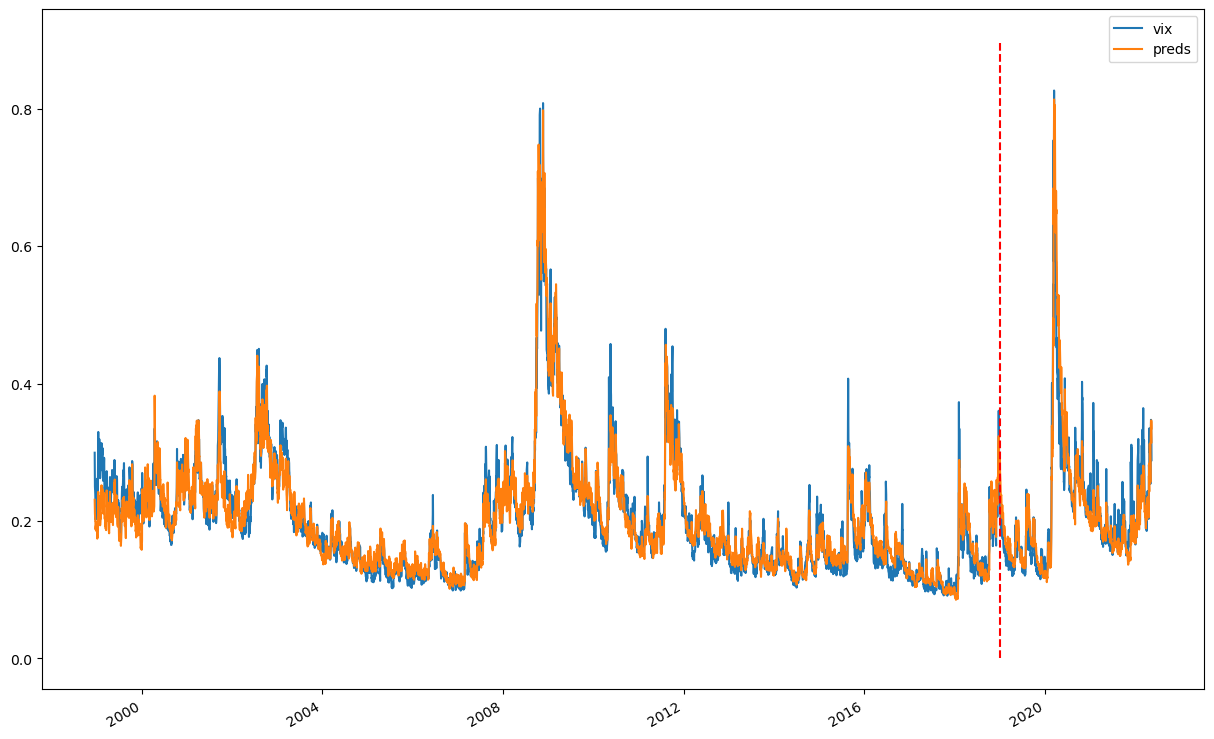

In [31]:
df_preds[['vix', 'preds']].plot(figsize=(15, 10))
plt.vlines(test_start_date, 0, 0.9, linestyles='dashed', colors='red')